In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch import nn
from torch import optim
import json
from PIL import Image
import io
import cv2
import torchvision.transforms.functional as TF
from torchvision.utils import save_image
from torchvision.transforms import ToPILImage
from matplotlib import pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data
import torch.optim as optim
from torch.optim import lr_scheduler
import tqdm
import time
import os
import copy
import pickle
import urllib.request
import requests
from matplotlib.pyplot import imshow
import random
from utils import *

In [22]:
#Function to display image and predicted class
def imstats(name):
    # read in image and view it
    x = readim(name, forward_normalize) 
    imshow_tensor(x[0], inv_normalize)

    #get predicted class and probability
    prob = lay2(pretrained_model(x.cuda()))
    maxcls = prob.max(1)
    print("Class is {} ({}) with confidence {}%".format(maxcls.indices.item(),class_dict[maxcls.indices.item()],round(maxcls.values.item()*100,4)))

(1200, 1296)


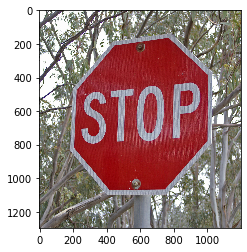

In [3]:
#Get classes
CLASS_URL = 'https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'
class_dict = pickle.load(urllib.request.urlopen(CLASS_URL))

#Retrieve image and assign class
IMG_URL = "https://upload.wikimedia.org/wikipedia/commons/thumb/f/f9/STOP_sign.jpg/1200px-STOP_sign.jpg"
classidx = 919
response = requests.get(IMG_URL)
img = Image.open(io.BytesIO(response.content))
print(img.size)
imshow(img)

In [4]:
#Model parameters
model_img_size = 224
model_transform = transforms.Compose([transforms.Resize((model_img_size,model_img_size)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
forward_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

print(type(img))
img_input = model_transform(img)
#img_input = img_input.unsqueeze(0)
#img_input = Variable(img_input)
img_input.shape

<class 'PIL.JpegImagePlugin.JpegImageFile'>


torch.Size([3, 224, 224])

In [5]:
#Model definition
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pretrained_model = models.resnet101(pretrained=True)
pretrained_model.to(device)
pretrained_model.eval()

#Pass input through model
img_input = img_input.to(device)
pred = pretrained_model(img_input.unsqueeze(0))

#Use softmax to get predicted probability and view it
lay2 = torch.nn.Softmax(dim=1)
prob = lay2(pred)
maxOcls = prob.max(1)
print("Class is {} ({}) with confidence {}%".format(maxOcls.indices.item(),class_dict[maxOcls.indices.item()],maxOcls.values.item()*100))

Class is 919 (street sign) with confidence 99.44760203361511%


<class 'torch.Tensor'>


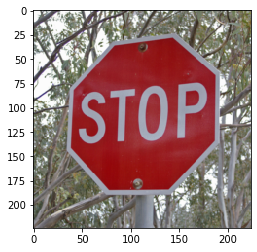

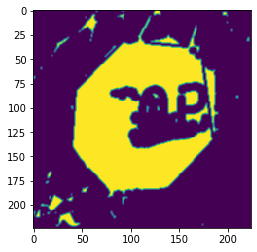

In [6]:
def get_object_mask(input_image):
    #print(test[-3][:])
    test = inv_normalize(input_image)
    test = np.uint8(test.numpy()*255).transpose((1,2,0))
    #test = 1 - test
    #test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(test, cv2.COLOR_RGB2GRAY)
    th, thgray = cv2.threshold(gray, 75, 255, cv2.THRESH_BINARY_INV); 
    #blurred = cv2.GaussianBlur(thgray, (9, 9), 0)
    th, blurred = cv2.threshold(thgray, 50, 255, cv2.THRESH_BINARY); 
    edged = cv2.Canny(blurred, 1, 250, L2gradient=True)   
    #imgplot = plt.imshow(blurred, cmap="gray")
    #plt.show()
    #imshow(input_image[0])
    #applying closing function
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
    closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)    #finding_contours
    (cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)   
    #cnts = [] #only for plate class 
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        cv2.drawContours(closed, [approx], -1, (0, 255, 0), 2)    
    th, im_th = cv2.threshold(closed, 254, 255, cv2.THRESH_BINARY_INV);    
    h, w = im_th.shape[:2]
    im_floodfill = im_th.copy()
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 0);    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)    # Combine the two images to get the foreground.
    #imshow(im_th)
    #plt.show()
    #imshow(im_floodfill_inv)
    #plt.show()
    im_out = im_th ^ im_floodfill_inv
    im_out = cv2.GaussianBlur(im_out, (3, 3), 0)
    return im_out
print(type(img_input))
imshow_tensor(img_input.cpu(),inv_normalize)
imgplot = plt.imshow(get_object_mask(img_input.cpu()))
plt.show()

In [7]:
#Testing classes. Likely unnecessary
adv = [598, 697, 898, 567, 69, 855, 641, 600, 942]
fold = "c0.3_sz228_shiftF/"
#targidx = np.random.randint(0,1000)
targidx = adv[1]
print(targidx)

697


In [24]:


sz = 130   #Length of input signal
c = .5     #Ambient light ratio

# change of variable term to optimise on
w = torch.rand([3,sz,1], requires_grad=True, dtype=torch.float, device=device)

#Create the mask to only illuminate the object
mask = torch.tensor(get_object_mask(img_input.cpu()), dtype=torch.float, device=device)
mask = mask / torch.max(mask)

#The shutter function is encoded into the convolution layer
lay = torch.nn.Conv1d(1,1,5)

#Manually setting the weights and bias so the  shutter acts as a box filter
lay.weight.data = torch.full([1,1,5,1], .2, requires_grad=True, dtype=torch.float, device=device)
lay.bias.data = torch.zeros(1, requires_grad=True, dtype=torch.float, device=device)

#Target and original class labels
target = torch.tensor([targidx], dtype=torch.long, device=device)
orig = torch.tensor([classidx], dtype=torch.long, device=device)

#Model parameters
lr = 1e-1
n_epochs = 1000
optimizer = optim.SGD([w], lr=lr)
loss_fn = nn.CrossEntropyLoss()

Switching from untarget to target 637



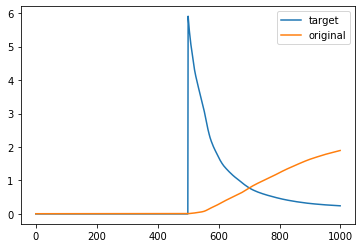

In [25]:
#Track the loss to target and original class
targloss = []
origloss = []

#Optimisation loop. initially untargeted
for epoch in tqdm.tqdm_notebook(range(n_epochs)):
    
    #Switch to targeted at halfway point
    half = epoch < n_epochs/2
    if epoch == n_epochs/2:
        tops = out.topk(2).indices[0]
        targidx = tops[0].item() if tops[0].item() != classidx else tops[1].item()
        target = torch.tensor([targidx], dtype=torch.long, device=device)
        print("Switching from untarget to target {}".format(targidx))
        
    #Compute g(y) to get X_adv
    oot = stack(w,228)             #stack the signal to fit the input size
    #oot = shift_operation(oot, np.random.randint(0,228))
    #oot = scale_operation(oot, np.random.rand(1)[0]+1)
    
    #Fit w into the range [0,1]. new_w is the same as ft
    new_w = .5 * (torch.tanh(oot) + 1)
    
    #Convolution of ft and the shutter
    gy = lay(new_w.unsqueeze(0).view([3,1,228,1])).view([1,3,224,1])[0]  
    
    #Mask the signal to only affect the object
    gy_mask = gy * mask
    
    #input calculation:
        #combine ambient light with attack signal, and multiply by image
        #multiplication must take space in the pre-normalised state, so inverse normalise the input
        #afterwards, renormalise to fit the model expectations
    #inp = ((1-mask) + mask*(c + (1-c)*gy_mask))*inv_normalize(img_input)   WHY DID WE ASSUME BACKGROUND AT FULL ILLUM?
    inp = (c + (1-c)*gy_mask)*inv_normalize(img_input)   
    inp = forward_normalize(inp)
    out = pretrained_model(inp.unsqueeze(0))
    
    #Calculate Loss depended on if targeted or untargeted
    if not half: targLoss = loss_fn(out, target)
    origLoss = loss_fn(out, orig)
    loss = -origLoss if half else targLoss
    targloss.append(0 if half else targLoss)
    origloss.append(origLoss)
    loss.backward()
    
    
    optimizer.step()
    
    optimizer.zero_grad()
    
#View original loss and target loss
plt.plot(targloss, label="target")
plt.plot(origloss, label="original")
plt.legend()
plt.show()

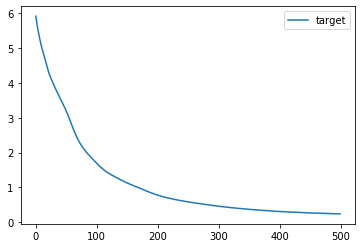

In [26]:
#View target loss after switch to targeted
plt.plot(targloss[n_epochs//2:], label="target")
plt.legend()
plt.show()

In [27]:
#Create softmax layer to view probabilities
lay2 = torch.nn.Softmax(dim=1)
prob = lay2(out)
maxcls = prob.max(1)
print(prob[0][targidx])
print(prob[0][classidx])
print("Class is {} ({}) with confidence {}%".format(maxcls.indices.item(),class_dict[maxcls.indices.item()],maxcls.values.item()*100))

tensor(0.7846, device='cuda:0', grad_fn=<SelectBackward>)
tensor(0.1502, device='cuda:0', grad_fn=<SelectBackward>)
Class is 637 (mailbox, letter box) with confidence 78.46189141273499%


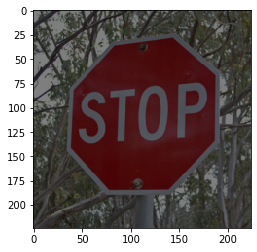

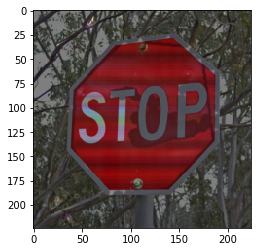

In [33]:
#View input image and adversarial image. Save both
imshow_tensor(forward_normalize(inv_normalize(img_input.cpu())*c), inv_normalize)
imshow_tensor(inp.detach().cpu(),inv_normalize)

saveim(forward_normalize(inv_normalize(img_input.cpu())*c), "original_{}.png".format(classidx),inv_normalize)
saveim(inp, "src{}_c{}_sz{}_tg{}.png".format(classidx,c,sz,targidx),inv_normalize)

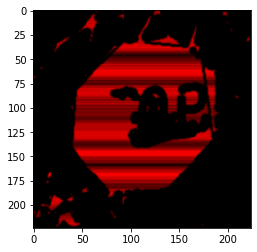

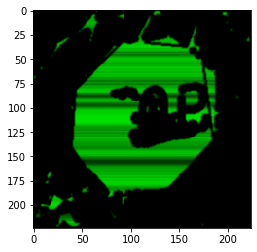

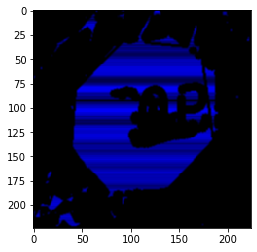

In [31]:
#View the attack signal colour channels separately
test = torch.ones([3,224,224], device=device)
re = test * split(gy_mask,0)
gr = test * split(gy_mask,1)
bl = test * split(gy_mask,2)
imshow_tensor(forward_normalize(re.detach().cpu()), inv_normalize)
imshow_tensor(forward_normalize(gr.detach().cpu()), inv_normalize)
imshow_tensor(forward_normalize(bl.detach().cpu()), inv_normalize)

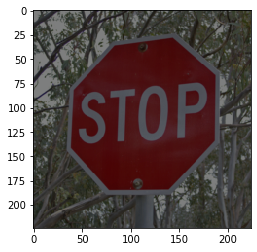

Class is 919 (street sign) with confidence 99.8318%


In [34]:
imstats("original_919.png")